# Monitoring of model
 Evaluate model on data and obtain metrics of performance

## Load libraries

In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [6]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data to evaluate

Load variables names from file

In [8]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [9]:
import os
import joblib
# load model
#modelo = joblib.load("ModeloV2TodosMenosVariables.pkl") 
#variables = open('./ModeloV2TodosMenosVariables.txt','r')
modelo = joblib.load("ModeloBite.pkl") 
variables = open('./ModeloBite0.txt','r')

In [10]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

## Veo si puedo sacar los nombres directo del modelo q cargue
## Veo como cargar el punto de corte

In [11]:
variables = open('./ModeloBite.txt','r')
var_input = variables.read()

#1er prueba
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', 
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count','01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [12]:
#2da prueba
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', 
    '01_branch_fraud', '01_location_fraud',
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    'receiver_transaction_count','01_sender_sending_days',
    'branch_working_days', '01_net_amount_receiver', 
    'sender_minutes_since_last_transaction_2days', 
    'sender_days_to_last_transaction_365', 
    'sender_days_to_last_transaction_7m', '01_hour_receiver']

In [13]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [14]:
# Uso esto para sacar el punto de corte. Cuando lo pueda guardar esta celda se va
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

#saco el punto de corte del primer centil para aplicarlo al test
corte_01 = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_03 = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
corte_04 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==10].min()

In [15]:
corte

1.758744333963758e-08

In [16]:
corte_01

1.02696063113117e-06

In [17]:
Y_c['pred_corte'] = Y_c['score_rf']>corte_01
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,16708132,16141
1,12,583


In [18]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

In [19]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")

testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

## Apply model

In [20]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [21]:
testeo['target'].value_counts(dropna=False)

target
False    32966471
True          818
Name: count, dtype: int64

In [22]:
Y_target.shape

(32967289, 8)

In [23]:
#replace nan with 0
#testeo['01_sender_minutes_since_last_transaction_2days'] = testeo['01_sender_minutes_since_last_transaction_2days'].fillna(0)
#testeo['01_sender_days_to_last_transaction_365'] = testeo['01_sender_days_to_last_transaction_365'].fillna(0)
#testeo['01_sender_days_to_last_transaction_7m'] = testeo['01_sender_days_to_last_transaction_7m'].fillna(0)

In [24]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [25]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [26]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,32966451,20
1,315,503


In [27]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,32637833,328638
1,39,779


<Axes: xlabel='score_rf', ylabel='Count'>

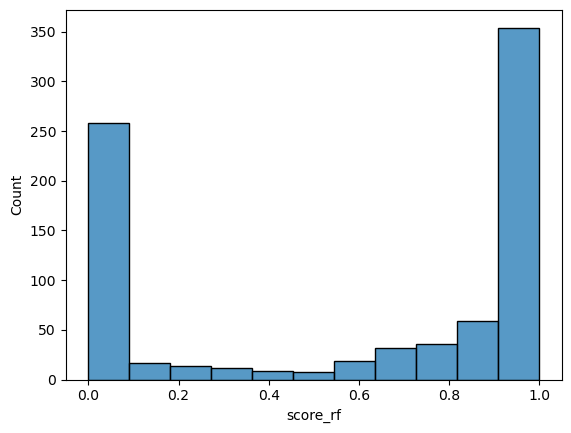

In [28]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [29]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
0.9743276283618582


In [30]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,328894,779
2,329657,16
3,329671,2
4,329670,3
5,329670,3
...,...,...
96,329673,0
97,329673,0
98,329673,0


In [31]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             1.756117e-08  1.000000e+00
2             5.069150e-09  1.756114e-08
3             2.493566e-09  5.069130e-09
4             1.514816e-09  2.493562e-09
5             1.029196e-09  1.514807e-09
...                    ...           ...
96            3.502652e-13  4.244974e-13
97            2.769312e-13  3.502652e-13
98            2.032829e-13  2.769306e-13
99            1.256887e-13  2.032829e-13
100           1.830715e-15  1.256886e-13

[100 rows x 2 columns]

In [32]:
#PERC = pd.crosstab(Y_c.FRAUD_DECILE[testeo['mes']>8], Y_c.target[testeo['mes']>8])
#PERC.to_csv ('./percentiles.csv')

## Analizo distintos puntos de corte

In [33]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [34]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['targetF'])

targetF,False,True
mes,,
1,3583,78
2,3800,38
3,6316,23
4,2095,61
5,2121,45
6,2180,66
7,2130,30
8,2205,37
9,2469,28


In [35]:
pd.crosstab(tes_corte_01['date_receiver'].dt.year, Y_c_corte_01['targetF'])

targetF,False,True
date_receiver,,
2023,26362,418
2024,8061,23


In [36]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_02'] = Y_c['score_rf']>corte_02
tes_corte_02 = testeo[Y_c['pred_corte_02']==True]
Y_c_corte_02 = Y_c[Y_c['pred_corte_02']==True]

pd.crosstab(tes_corte_02['mes'], Y_c_corte_02['targetF'])

targetF,False,True
mes,,
1,7560,80
2,7604,39
3,11146,25
4,4185,61
5,4232,45
6,4296,67
7,4342,30
8,4464,37
9,4806,31


In [37]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_03'] = Y_c['score_rf']>corte_03
tes_corte_03 = testeo[Y_c['pred_corte_03']==True]
Y_c_corte_03 = Y_c[Y_c['pred_corte_03']==True]

pd.crosstab(tes_corte_03['mes'], Y_c_corte_03['targetF'])

targetF,False,True
mes,,
1,11486,82
2,11510,39
3,15654,25
4,6251,61
5,6337,45
6,6468,67
7,6580,30
8,6637,37
9,7174,33


In [38]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_04'] = Y_c['score_rf']>corte_04
tes_corte_04 = testeo[Y_c['pred_corte_04']==True]
Y_c_corte_04 = Y_c[Y_c['pred_corte_04']==True]

pd.crosstab(tes_corte_04['mes'], Y_c_corte_04['targetF'])

targetF,False,True
mes,,
1,15287,83
2,15395,39
3,20198,27
4,8425,61
5,8421,45
6,8643,67
7,8770,30
8,8859,37
9,9511,34


In [39]:
pd.crosstab(tes_corte_04['date_receiver'].dt.year, Y_c_corte_04['targetF'])

targetF,False,True
date_receiver,,
2023,105570,445
2024,27457,31


## Curva ROC y FP

In [40]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [41]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.926647054582656
ROC FRAUD TESTEO:
0.9711769412269335


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.9530119125282507
Precision FRAUD TESTEO:
0.0023647838453996
Recall FRAUD TESTEO:
0.9523227383863081


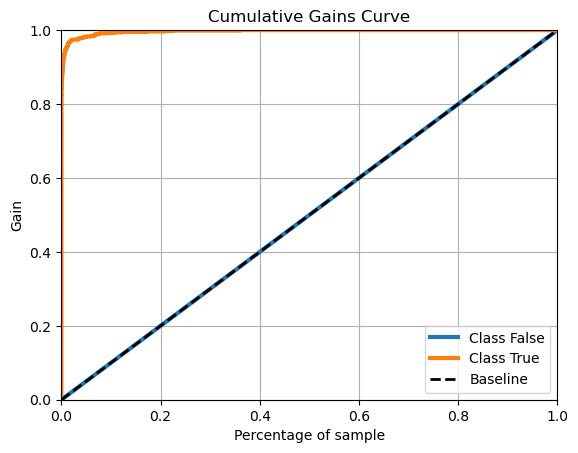

In [42]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


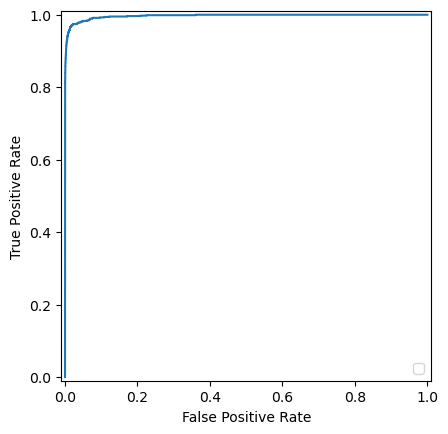

In [43]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

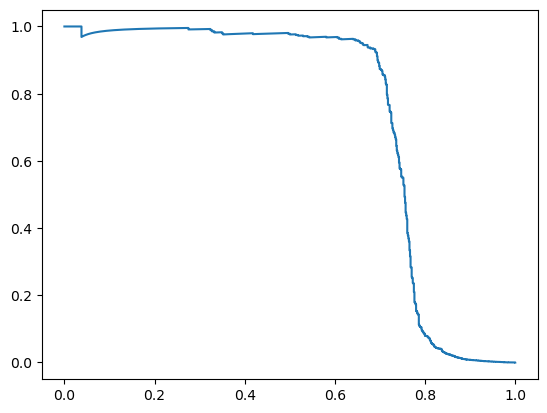

In [44]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [45]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

0.8002735978112175

## Monthly analysis

In [46]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,3732738,146
2,3887100,72
3,4381826,61
4,2116204,87
5,2289892,69
6,2193663,101
7,2314224,50
8,2296945,68
9,2420668,75


In [47]:
#Veo cuantos falsos positivos tengo con el punto de corte
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['target'])

target,False,True
mes,,
1,37929,140
2,38426,68
3,46385,53
4,20965,86
5,21484,69
6,22073,99
7,22060,50
8,21910,68
9,23892,66


In [48]:
Tabla_mes = pd.DataFrame(pd.concat([testeo['mes'],testeo['fraud_classification'], 
                                     Y_c['FRAUD_DECILE'], Y_c['target']],axis=1))

In [49]:
Tabla_mes[Tabla_mes['target']==True]
pd.crosstab(Tabla_mes.mes, Tabla_mes.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,38084,38037,37562,37012,37111,37085,36842,36932,37097,37385,37120,37171,37000,37102,36958,37100,37092,37050,37125,37049,37128,37328,37364,37141,37191,37560,37314,37154,37101,37066,37170,36942,37499,37374,37491,37520,37531,37735,37491,37579,37584,37572,37483,37039,37043,37508,37411,37411,37583,37400,37305,37618,37645,37609,37287,37456,37927,37685,37467,37602,37293,37771,37536,37508,37880,37158,37630,37433,37721,37388,37696,37606,37438,37432,37310,37289,37267,37642,37354,37306,37139,37342,37148,37324,36982,37550,37057,36991,37258,37129,37112,37031,36848,36846,37103,36959,36789,37046,37347,37997
2,38520,38717,38945,38910,38717,38852,39180,38480,38892,38943,39097,39043,38933,39237,39063,39155,38743,39361,39216,39196,39537,38922,39397,39670,39173,39366,39437,39343,39289,39324,39422,39134,39129,39139,39425,39393,39022,38934,39240,39057,39064,39134,38884,38947,39104,38990,39462,39108,38670,38860,39067,38810,38611,39380,39056,39155,38655,38728,38669,38909,38736,38703,38863,38778,38251,38635,38739,38457,38457,38528,38424,38627,38787,38507,38617,38306,38691,38768,38465,38617,38678,38354,38649,38512,38394,38404,38498,38851,38478,38786,38470,38496,38281,38624,38459,38818,38553,38670,38504,38921
3,46486,43948,44013,44234,44218,44235,44061,44340,43898,43861,44189,44217,44124,44203,44033,44412,44460,44331,44148,44470,44222,44183,44220,44504,44229,44277,44388,44365,44319,44220,44222,43945,44046,44195,44074,44245,44249,44053,44299,44202,44036,43889,44443,44268,44040,43824,43952,44092,44003,44174,43932,44449,43865,43822,43327,43868,43797,43593,43966,43547,43912,43585,43838,43707,43479,43810,43730,43680,43410,43351,43236,43152,43489,43336,43410,43585,43045,43255,43116,43148,43502,43165,43281,43260,43228,43299,43668,43446,43402,43056,43019,43373,43441,43299,43242,42892,42747,42947,42496,42625
4,21067,20932,20528,20910,21067,20868,20677,20670,20760,20699,20852,20591,20719,20749,20516,20621,20720,20672,20771,20638,20518,20687,20618,20575,20768,20857,20702,20787,20511,20885,20574,20848,20604,20704,20677,20529,20585,20804,20875,20634,20684,20806,20711,20955,20698,20758,20856,20797,20691,20904,21120,21061,20895,20834,21016,20772,21094,20824,21003,20967,20970,20725,20827,21038,21356,21175,21091,21522,21205,21476,21353,21503,21221,21367,21547,21557,21349,21791,21672,21488,21460,21720,21608,22042,21848,21928,22238,21996,22167,22185,22259,22312,22527,22466,22349,22453,22494,22420,22839,22532
5,21569,22843,23121,23173,23249,23405,23387,23233,23425,23328,23067,23441,23191,23229,23293,22847,23259,22994,23185,23278,23076,23100,22879,23292,22842,22766,22954,22709,22937,22911,23120,23054,22638,22988,23161,22764,22964,23186,22853,22764,22511,22608,22844,22954,22934,22445,22780,22488,22666,22781,22707,22750,22804,22796,22718,22748,22515,23051,22827,22810,22901,22925,22744,22513,22712,22707,22888,22930,22894,23011,22853,22719,23008,22717,22928,22840,22896,22843,22911,22827,22719,22907,22854,22720,22899,22652,22823,23094,22798,23035,23120,22871,22910,22846,22876,23083,22823,22845,22876,22231
6,22185,23231,23484,23648,23549,23160,23574,23528,23253,23307,23254,22794,22947,22923,22768,22953,22833,22714,22821,22650,22554,22725,22529,22532,22454,22235,22323,22313,22373,22259,22337,22046,22130,22464,22362,21811,22037,22251,21729,22197,22009,21981,21645,21906,22019,22114,21655,22104,21806,21936,21893,21711,21646,21843,21450,21882,21969,21565,21710,21729,21739,21717,21436,21440,21780,21826,21182,21459,21543,21540,21483,21373,21375,21427,21264,21405,21711,21447,21221,21535,21311,21440,21356,21293,21469,21173,21202,21100,21121,20859,21234,20869,20938,20828,21052,20801,207

In [50]:
pd.crosstab(Tabla_mes.mes[Tabla_mes['target']==True], Tabla_mes.FRAUD_DECILE[Tabla_mes['target']==True])

FRAUD_DECILE,1,2,3,4,5,6,7,8,10,11,13,18,21,23,37
mes,,,,,,,,,,,,,,,
1,140,4,0,0,0,1,0,0,0,0,0,1,0,0,0
2,68,2,0,0,0,0,0,1,1,0,0,0,0,0,0
3,53,4,1,1,1,0,0,0,0,0,0,0,1,0,0
4,86,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,99,1,0,0,1,0,0,0,0,0,0,0,0,0,0
7,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,66,2,0,0,1,1,3,0,0,1,0,0,0,0,1


In [51]:
Tabla_mes.loc[Tabla_mes['target']==True,['mes','fraud_classification','FRAUD_DECILE']]

,mes,fraud_classification,FRAUD_DECILE
99521,1,Real,1
136425,2,Distraction,1
166402,3,Distraction,1
180042,6,Real,1
187184,1,Distraction,1
...,...,...,...
31918511,3,Real,5
32220826,3,Real,2
32669531,3,Real,2
32748885,3,Real,3


# Monthly indicators

In [52]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        if not subset_mes.empty:
            precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte_03'])
            recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte_03'])
            summary_metrics.loc[i,'month'] = m
            summary_metrics.loc[i,'year'] = y
            summary_metrics.loc[i,'precision'] = precision
            summary_metrics.loc[i,'recall'] = recall
            summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte_03'].sum()
            summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
            summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte_03']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
            #print ('Year:', y, 'Month:',m)
            #print ('Precision:', precision, 'Recall:',recall)
            i = i+1
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.011511,0.96875,5386,118,64,62
0,2,2023,0.005969,1.0,5696,58,34,34
5,3,2023,0.003192,0.954545,6579,44,22,21
1,4,2023,0.009664,1.0,6312,87,61,61
2,5,2023,0.007051,1.0,6382,69,45,45
3,6,2023,0.010252,0.957143,6535,101,70,67
4,7,2023,0.004539,1.0,6610,50,30,30
7,8,2023,0.005544,1.0,6674,68,37,37
8,9,2023,0.004579,0.75,7207,75,44,33
9,10,2023,0.003527,0.8125,7372,46,32,26


In [53]:
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.011511,0.96875,5386,118,64,62
0,2,2023,0.005969,1.0,5696,58,34,34
5,3,2023,0.003192,0.954545,6579,44,22,21
1,4,2023,0.009664,1.0,6312,87,61,61
2,5,2023,0.007051,1.0,6382,69,45,45
3,6,2023,0.010252,0.957143,6535,101,70,67
4,7,2023,0.004539,1.0,6610,50,30,30
7,8,2023,0.005544,1.0,6674,68,37,37
8,9,2023,0.004579,0.75,7207,75,44,33
9,10,2023,0.003527,0.8125,7372,46,32,26


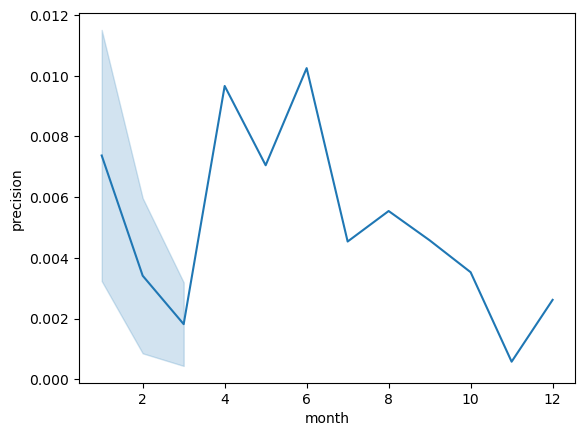

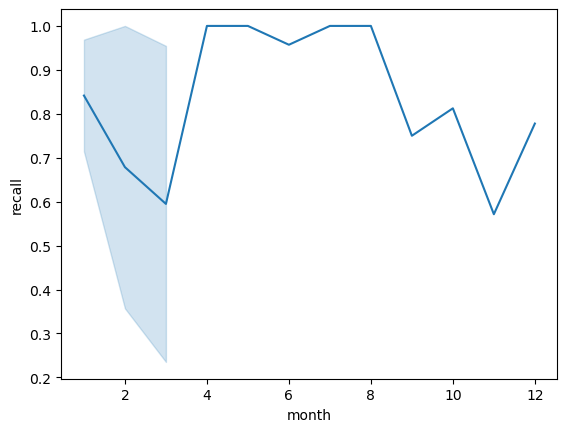

In [54]:
# Recall and precision by month
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()

## Daily analysis

In [55]:
tes_corte_01['date_receiver'].dt.floor('d')

403        2023-01-19
1017       2023-06-04
1379       2023-04-29
2474       2023-05-21
2778       2023-04-07
              ...    
32963714   2024-03-27
32964465   2024-03-17
32964601   2024-03-22
32965756   2024-03-06
32967184   2024-03-09
Name: date_receiver, Length: 34864, dtype: datetime64[ns]

In [56]:
ALERTAS_01 = pd.crosstab(tes_corte_01['date_receiver'].dt.floor('d'), Y_c_corte_01['targetF'])
ALERTAS_01.to_csv ('./alertas.csv')

In [57]:
ALERTAS_01

targetF,False,True
date_receiver,,
2023-01-01,15,0
2023-01-02,51,0
2023-01-03,48,0
2023-01-04,59,11
2023-01-05,52,19
...,...,...
2024-03-26,38,0
2024-03-27,72,0
2024-03-28,33,0


In [58]:
FRAUDES = pd.crosstab(testeo['date_receiver'].dt.floor('d'), Y_c['targetF'])
#FRAUDES.to_csv ('./fraudes.csv')

In [59]:
FRAUDES

targetF,False,True
date_receiver,,
2023-01-01,15754,0
2023-01-02,58123,0
2023-01-03,48448,0
2023-01-04,44212,11
2023-01-05,43613,20
...,...,...
2024-03-27,52849,0
2024-03-28,48518,0
2024-03-29,65119,0


## Busco fraudes q no faltan

In [65]:
faltantes = (testeo['id_receiver'].between(5631,5659)) & (testeo['id_branch'] =='A24793')
X_faltantes = testeo[faltantes]
Y_c_faltantes = Y_c[faltantes]
Y_c_faltantes[['pred_corte','pred_corte_01','pred_corte_02','pred_corte_03']].value_counts()

pred_corte  pred_corte_01  pred_corte_02  pred_corte_03
False       False          False          False            27
Name: count, dtype: int64

In [61]:
X_faltantes[var_input].describe()

,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_var_range_hist,sender_days_to_last_transaction_more7m,receiver_transaction_count,01_sender_sending_days,branch_working_days,01_net_amount_receiver,sender_minutes_since_last_transaction_2days,sender_days_to_last_transaction_365,sender_days_to_last_transaction_7m,01_hour_receiver
count,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.0,20.000000,20.0,19.000000,20.0,20.0,19.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000
mean,6.900000,1986.300000,0.0,3.300000,1.750000,0.550000,0.0,4.950000,0.0,1.820587,0.0,1.0,0.228168,265.0,0.366698,116.050000,10.600000,10.600000,0.947917
std,17.050698,4.280925,0.0,1.380313,0.638666,0.510418,0.0,3.677456,0.0,1.731328,0.0,0.0,0.152718,0.0,0.080913,482.873687,9.360612,9.360612,0.018511
min,1.000000,1979.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.639731,0.0,1.0,0.001397,265.0,0.237641,0.000000,0.000000,0.000000,0.916667
25%,2.000000,1983.750000,0.0,2.750000,1.750000,0.000000,0.0,2.000000,0.0,0.893386,0.0,1.0,0.055866,265.0,0.323557,0.000000,2.000000,2.000000,0.947917
50%,2.000000,1988.000000,0.0,4.000000,2.000000,1.000000,0.0,4.000000,0.0,1.379310,0.0,1.0,0.326816,265.0,0.361945,0.000000,6.000000,6.000000,0.958333
75%,4.000000,1988.000000,0.0,4.000000,2.000000,1.000000,0.0,8.250000,0.0,1.964305,0.0,1.0,0.360335,265.0,0.402161,0.000000,22.000000,22.000000,0.958333
max,79.000000,1999.000000,0.0,5.000000,3.000000,1.000000,0.0,13.000000,0.0,8.252632,0.0,1.0,0.368715,265.0,0.584962,2162.000000,24.000000,24.000000,0.958333


In [62]:
#testeo.loc[(testeo['id_receiver'] ==5631) & (testeo['id_branch'] =='A24793')] 

testeo.loc[(testeo['id_receiver'].between(5631,5659)) & (testeo['id_branch'] =='A24793')] 

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target,id_payout_G,year
30745840,A24793,5656,2024-03-22 10:11:13.040,TX1505,NN,10326891,900.0,GUA,GUA6,TX,266,263.0,33.0,USA,None,46982.0,10.0,0.0,2001.0,TX,0,0,2,0,2,0,2.0,800.000000,0,15.0,3,10,False,True,1.125000,False,False,False,False,True,False,33.0,0,33.0,0,0.0,0.0,0.147368,0.367318,0.047186,0.329041,0.000000,0.000000,0.090411,0.157143,0.416667,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2024
30961307,A24793,5644,2024-03-21 23:55:40.800,TX1505,NN,10339243,1150.0,MEX,MEX35,TX,265,259.0,14.0,USA,None,20943.0,2.0,0.0,1988.0,TX,0,0,4,2,1,0,2.0,800.000000,0,1.0,3,23,True,True,1.437500,False,False,False,False,False,True,14.0,0,14.0,0,0.0,0.0,0.000000,0.361732,0.047017,0.420442,0.000000,0.000000,0.038356,0.066667,0.958333,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,2024
31213352,A24793,5640,2024-03-21 23:56:07.267,TX1505,NN,10345474,1450.0,MEX,MEX16,TX,265,258.0,6.0,USA,None,8925.0,1.0,0.0,1999.0,TX,0,0,5,3,1,0,7.0,1100.000000,0,1.0,3,23,True,True,1.318182,False,False,False,False,True,False,6.0,0,6.0,0,0.0,0.0,0.000000,0.360335,0.047017,0.530122,0.000000,0.000000,0.016438,0.028571,0.958333,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2024
31253540,A24793,5653,2024-03-21 23:55:40.800,TX1505,NN,10398602,650.0,MEX,MEX47,TX,265,184.0,7.0,USA,None,10558.0,2.0,0.0,1988.0,TX,0,0,4,2,1,0,2.0,800.000000,0,1.0,3,23,True,True,0.812500,False,False,False,False,False,True,7.0,0,7.0,0,0.0,0.0,0.000000,0.256983,0.047017,0.237641,0.000000,0.000000,0.019178,0.033333,0.958333,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,2024
31321486,A24793,5637,2024-03-21 23:45:05.103,TX1505,NN,10314303,1600.0,MEX,MEX47,TX,265,264.0,0.0,USA,None,159.0,4.0,0.0,1985.0,NC,0,0,1,1,0,0,13.0,642.307692,0,1.0,3,23,True,False,2.491018,False,False,False,False,False,True,0.0,0,0.0,0,159.0,159.0,0.000000,0.368715,0.047017,0.584962,0.055208,0.110417,0.000000,0.000000,0.958333,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,2024
31380509,A24793,5634,2024-03-21 22:18:05.113,TX1505,NN,10356048,650.0,MEX,MEX16,TX,265,255.0,2.0,USA,None,3030.0,4.0,0.0,1982.0,TX,0,0,4,2,0,0,9.

In [63]:
Y_c.loc[(testeo['id_receiver'].between(5631,5659)) & (testeo['id_branch'] =='A24793')] 

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,target,preds_rf,score_rf,pred_corte,FRAUD_DECILE,fraud_classification,targetF,pred_corte_01,pred_corte_02,pred_corte_03,pred_corte_04
30745840,False,False,False,False,True,False,False,False,False,5.121778e-14,False,100,None,False,False,False,False,False
30961307,False,False,False,True,False,False,False,False,False,7.181351e-11,False,22,None,False,False,False,False,False
31213352,False,False,False,True,False,False,False,False,False,1.620114e-10,False,15,None,False,False,False,False,False
31253540,False,False,False,True,False,False,False,False,False,1.924503e-10,False,13,None,False,False,False,False,False
31321486,False,False,False,True,False,False,False,False,False,3.305139e-09,False,3,None,False,False,False,False,False
31380509,False,False,False,True,False,False,False,False,False,2.110612e-10,False,13,None,False,False,False,False,False
31619975,False,False,False,True,False,False,False,False,False,4.425539e-11,False,28,None,False,False,False,False,False
31639464,False,False,False,False,True,False,False,False,False,2.324965e-12,False,77,None,False,False,False,False,False
31657291,False,False,False,False,True,False,False,False,False,1.505296e-11,False,44,None,False,False,False,False,False
31740059,False,False,False,True,False,False,False,False,False,1.640988e-10,False,15,None,False,False,False,False,False


In [66]:
Y_c.loc[(testeo['id_receiver'].between(1783,1783)) & (testeo['id_branch'] =='A20109'),'pred_corte_01'] 

31754334    True
Name: pred_corte_01, dtype: bool

In [67]:
faltantes = (testeo['id_receiver'].between(174,178)) & (testeo['id_branch'] =='A25879')
X_faltantes = testeo[faltantes]
Y_c_faltantes = Y_c[faltantes]
Y_c_faltantes[['pred_corte','pred_corte_01','pred_corte_02','pred_corte_03']].value_counts()

Series([], Name: count, dtype: int64)

In [76]:
testeo[(testeo['id_branch']=='A24570') & (testeo['id_receiver']==1883)]
testeo[(testeo['id_branch']=='A24570') & (testeo['id_receiver']==1883)]

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target,id_payout_G,year
16726691,A24570,1883,2023-09-01 19:33:58.957,NY1438,T085,10617643,128.0,GUA,GUA11,NY,57,NaN,0.0,USA,None,0.0,6.0,0.0,1806.0,NY,0,0,7,2,7,0,0.0,NaN,0,4.0,9,19,False,True,NaN,False,False,False,False,True,False,0.0,0,0.0,0,0.0,0.0,0.029703,NaN,0.025658,0.046209,0.0,0.0,0.0,0.0,0.791667,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2023


In [90]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Faltantes.parquet")

testeo2 = tes
Y_target2 = pd.DataFrame(tes['target']) 

In [91]:
testeo2['01_var_range_hist'] = testeo.loc[(testeo['id_branch']=='A24570') & (testeo['id_receiver']==1883),'01_var_range_hist']
testeo2['01_var_range_hist'] 

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
Name: 01_var_range_hist, dtype: float64

In [92]:
testeo_data_pred_rf2 = modelo.predict(testeo2[var_input])
probab_rf2 = modelo.predict_proba(testeo2[var_input])
score_rf2 = np.delete(probab_rf2, np.s_[0], axis=1)

Y_c2 = Y_target2.copy()
Y_c2['preds_rf'] = testeo_data_pred_rf2
Y_c2['score_rf'] = score_rf2


In [93]:
Y_c2['pred_corte_01'] = Y_c2['score_rf']>corte_01
pd.DataFrame(confusion_matrix(Y_c2['target'], Y_c2['pred_corte_01']))

,0,1
0,4,0
1,3,0


In [94]:
Y_c2['pred_corte_02'] = Y_c2['score_rf']>corte_02
pd.DataFrame(confusion_matrix(Y_c2['target'], Y_c2['pred_corte_02']))

,0,1
0,4,0
1,3,0


In [97]:
Y_c2['pred_corte'] = Y_c2['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c2['target'], Y_c2['pred_corte']))

,0,1
0,4,0
1,3,0
